In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Tải dữ liệu (thay đường dẫn nếu cần)
train_df = pd.read_csv('data/train.csv')  # Hoặc upload từ Kaggle
test_df = pd.read_csv('data/test.csv')

print("Kích thước train:", train_df.shape)
print("Kích thước test:", test_df.shape)
print("\nCột dữ liệu:", train_df.columns.tolist())
print("\nMô tả ngắn gọn:\n", train_df.describe())

Kích thước train: (891, 12)
Kích thước test: (418, 11)

Cột dữ liệu: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Mô tả ngắn gọn:
        PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%  

In [2]:
# Info cơ bản
print(train_df.info())
print("\nMissing values:\n", train_df.isnull().sum())

# Thống kê target
print("\nTỷ lệ sống sót:", train_df['Survived'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Missing values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked    

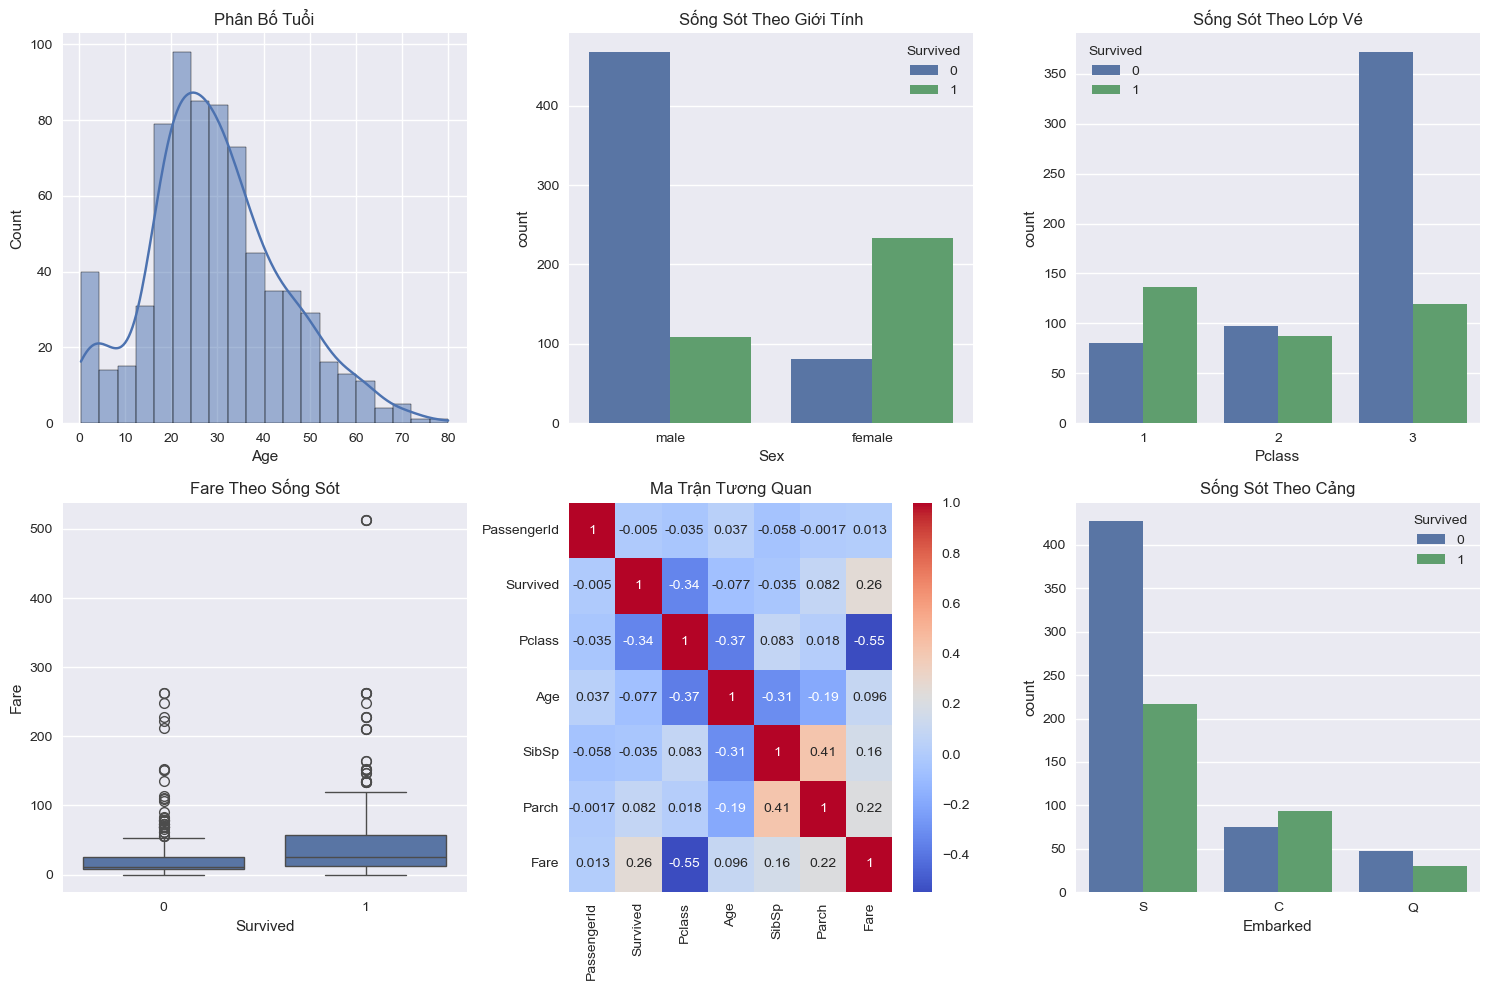

In [3]:
# Setup viz
plt.style.use('seaborn-v0_8')  # Style đẹp
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Age distribution
sns.histplot(data=train_df, x='Age', kde=True, ax=axes[0,0])
axes[0,0].set_title('Phân Bố Tuổi')

# 2. Survived by Sex
sns.countplot(data=train_df, x='Sex', hue='Survived', ax=axes[0,1])
axes[0,1].set_title('Sống Sót Theo Giới Tính')

# 3. Survived by Pclass
sns.countplot(data=train_df, x='Pclass', hue='Survived', ax=axes[0,2])
axes[0,2].set_title('Sống Sót Theo Lớp Vé')

# 4. Fare boxplot by Survived
sns.boxplot(data=train_df, x='Survived', y='Fare', ax=axes[1,0])
axes[1,0].set_title('Fare Theo Sống Sót')

# 5. Correlation heatmap (chỉ numeric)
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
sns.heatmap(train_df[numeric_cols].corr(), annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Ma Trận Tương Quan')

# 6. Embarked vs Survived
sns.countplot(data=train_df, x='Embarked', hue='Survived', ax=axes[1,2])
axes[1,2].set_title('Sống Sót Theo Cảng')

plt.tight_layout()
plt.show()

In [4]:
# Tạo feature mới: Family size
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
print(train_df['FamilySize'].value_counts())

# Cross-tab: Survived by FamilySize
print(pd.crosstab(train_df['FamilySize'], train_df['Survived'], normalize='index'))

FamilySize
1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: count, dtype: int64
Survived           0         1
FamilySize                    
1           0.696462  0.303538
2           0.447205  0.552795
3           0.421569  0.578431
4           0.275862  0.724138
5           0.800000  0.200000
6           0.863636  0.136364
7           0.666667  0.333333
8           1.000000  0.000000
11          1.000000  0.000000


In [6]:
# Copy data để tránh thay đổi gốc
df = train_df.copy()

# 1. Xử lý missing Age: Impute bằng median theo Pclass/Sex
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
df['Age'].fillna(df['Age'].median(), inplace=True)  # Fallback

# 2. Cabin: Lấy chữ cái đầu (deck), fill NaN bằng 'Unknown'
df['Cabin'] = df['Cabin'].astype(str).str[0]
df['Cabin'] = df['Cabin'].replace('nan', 'Unknown')

# 3. Embarked: Fill mode
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# 4. Encode categorical
le_sex = LabelEncoder()
df['Sex'] = le_sex.fit_transform(df['Sex'])  # 0=female, 1=male

le_emb = LabelEncoder()
df['Embarked'] = le_emb.fit_transform(df['Embarked'])

le_cabin = LabelEncoder()
df['Cabin'] = le_cabin.fit_transform(df['Cabin'])

# 5. Drop không cần: Name, Ticket, PassengerId (sau khi dùng nếu cần)
df.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

# 6. Scale numeric (Age, Fare, FamilySize)
scaler = StandardScaler()
numeric_features = ['Age', 'Fare', 'FamilySize']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

print("Sau preprocessing:\n", df.isnull().sum().sum())  # Nên =0
print("\nSample:\n", df.head())

Sau preprocessing:
 0

Sample:
    Survived  Pclass  Sex       Age  SibSp  Parch      Fare  Cabin  Embarked  \
0         0       3    1 -0.534891      1      0 -0.502445      8         2   
1         1       1    0  0.668392      1      0  0.786845      2         0   
2         1       3    0 -0.234070      0      0 -0.488854      8         2   
3         1       1    0  0.442776      1      0  0.420730      2         2   
4         0       3    1  0.442776      0      0 -0.486337      8         2   

   FamilySize  
0    0.059160  
1    0.059160  
2   -0.560975  
3    0.059160  
4   -0.560975  


In [7]:
# Split data
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict và evaluate
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

# Feature importance
importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_}).sort_values('Importance', ascending=False)
print("\nFeature Importance:\n", importances)

Accuracy: 0.7932960893854749

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       110
           1       0.75      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179


Confusion Matrix:
 [[94 16]
 [21 48]]

Feature Importance:
       Feature  Importance
1         Sex    0.264768
2         Age    0.228972
5        Fare    0.223696
6       Cabin    0.075255
0      Pclass    0.070611
8  FamilySize    0.049773
7    Embarked    0.033107
3       SibSp    0.032860
4       Parch    0.020957
